# *Advanced example* from the docs: Gaussian quarter ring

In [1]:
# Configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
try:
    from cobaya import run
except ImportError:
    sys.path.insert(0,'../../cobaya')
    from cobaya import run

### Defining the *Gaussian ring* likelihood and priors for its parameters

In [2]:
import numpy as np
from scipy import stats

def gauss_ring_logp(x, y):
    return stats.norm.logpdf(np.sqrt(x**2+y**2), loc=1, scale=0.02)

info = {"likelihood": {"ring": gauss_ring_logp}}

In [3]:

info["params"] = {
    "x": {"prior": {"min": 0, "max": 2}, "ref": 0.5, "proposal": 0.01},
    "y": {"prior": {"min": 0, "max": 2}, "ref": 0.5, "proposal": 0.01}}

### Defining *dynamical* derived parameters: radius and angle

In [4]:
get_r = lambda x,y: np.sqrt(x**2+y**2)
get_theta = lambda x,y: np.arctan(y/x)

info["params"]["r"] = {"derived": get_r}
info["params"]["theta"] = {"derived": get_theta,
                           "latex": r"\theta", "min": 0, "max": np.pi/2}

# N.B.: the options "min" and "max" for theta are not a prior (it is not a sampled parameter!)
# but the ranges used by GetDist to plot and derive marginal distributions for theta.

### Sample and plot!

In [5]:
# Very non-gaussian shape: increase the default convergence criterion and
# increase limit on tries before chain gets stuck
info["sampler"] = {"mcmc": {"Rminus1_stop": 0.001, "max_tries": 1000}}

from cobaya import run
updated_info, sampler = run(info)

[ring] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: x:0.5, y:0.5
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {ring: 5990.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-08-09 09:38:16 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.688
[mcmc]  - Convergence of means: R-1 = 19.398481 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.525
[mcmc]  - Convergence of means: R-1 = 3.315150 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.41

[mcmc] *WARNING* When combining chains, it is recommended to remove some initial fraction, e.g. 'skip_samples=0.3'


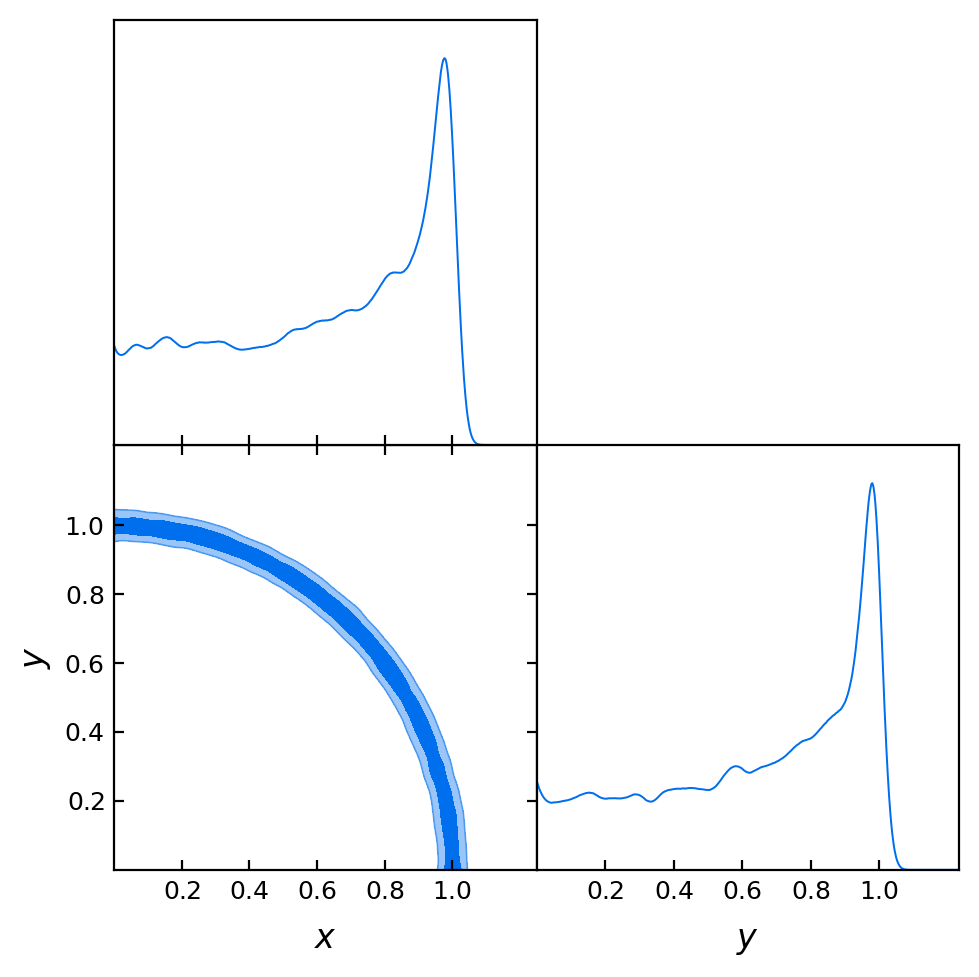

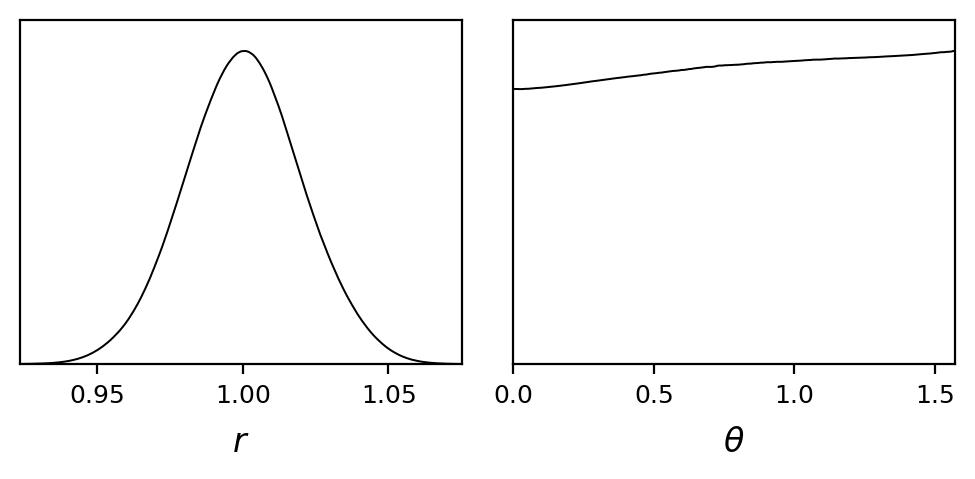

In [6]:
import getdist.plots as gdplt

gdsamples = sampler.products(to_getdist=True)["sample"]
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["x", "y"], filled=True)
gdplot.export("example_adv_ring.png")
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.plots_1d(gdsamples, ["r", "theta"], nx=2)
gdplot.export("example_adv_r_theta.png")

### Imposing a Gaussian band along $x=y$

In [7]:
info["prior"] = {"x_eq_y_band": lambda x, y: stats.norm.logpdf(x - y, loc=0, scale=0.3)}

from cobaya import run
updated_info_x_eq_y, sampler_x_eq_y = run(info)

[prior] *WARNING* External prior 'x_eq_y_band' loaded. Mind that it might not be normalized!
[ring] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: x:0.5, y:0.5
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {ring: 6020.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-08-09 09:38:33 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.727
[mcmc]  - Convergence of means: R-1 = 1.089851 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.650
[mcmc]  - Convergence of means: R-1 = 0.588121 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal 

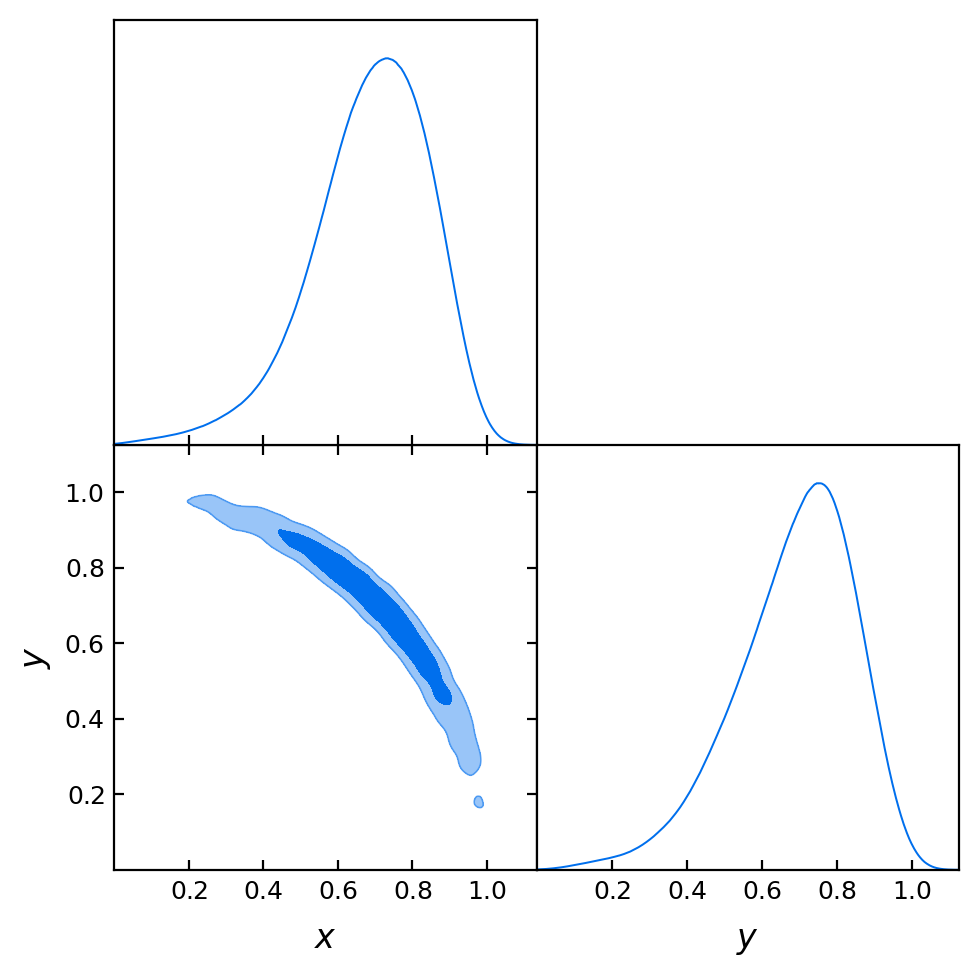

In [8]:
# load samples, removing first 30% as burn in
gdsamples_x_eq_y = sampler_x_eq_y.products(to_getdist=True, skip_samples=0.3)["sample"]
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples_x_eq_y, ["x", "y"], filled=True)
gdplot.export("example_adv_band.png")

## Alternative: $r$ and $\theta$ as derived parameters of the likelihood

In [9]:
# List available derived parameters in the 'output_params' option of the likelihood.
# To make room for that, you need assign the function to the option 'external'.
# Return both the log-likelihood and a dictionary of derived parameters.
def gauss_ring_logp_with_derived(x, y):
    r = np.sqrt(x**2+y**2)
    derived = {"r": r, "theta": np.arctan(y/x)}
    return stats.norm.logpdf(r, loc=1, scale=0.02), derived

info_alt = {"likelihood": {"ring":
    {"external": gauss_ring_logp_with_derived, "output_params": ["r", "theta"]}}}

# Now we don't need to *define* (but do need to *mention*) r or theta
# if we want their values included in the chain
info_alt["params"] = {
    "x": {"prior": {"min": 0, "max": 2}, "ref": 0.5, "proposal": 0.01},
    "y": {"prior": {"min": 0, "max": 2}, "ref": 0.5, "proposal": 0.01},
    "r": None,
    "theta": {"latex": r"\theta", "min": 0, "max": np.pi/2}}
# Copy the prior and sampler info from the old one
info_alt["prior"] = info["prior"]
info_alt["sampler"] = info["sampler"]

# And run
updated_info_alt, sampler_alt = run(info_alt)

[prior] *WARNING* External prior 'x_eq_y_band' loaded. Mind that it might not be normalized!
[ring] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: x:0.5, y:0.5
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {ring: 14900.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-08-09 09:38:43 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.660
[mcmc]  - Convergence of means: R-1 = 4.057590 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.479
[mcmc]  - Convergence of means: R-1 = 0.625906 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal

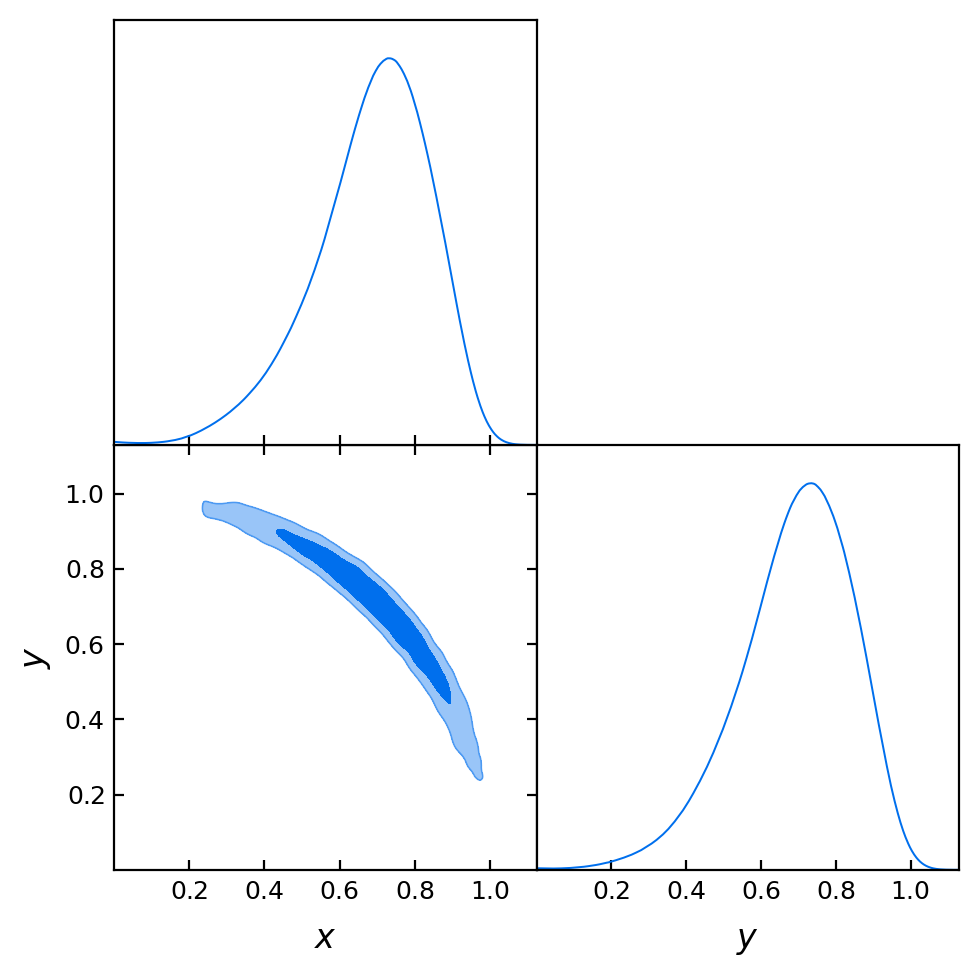

<Figure size 500x375 with 0 Axes>

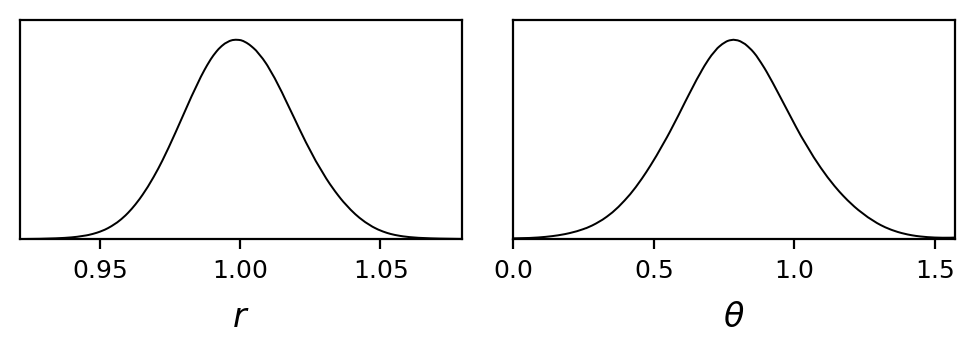

In [10]:
gdsamples_alt = sampler_alt.products(to_getdist=True, skip_samples=0.3)["sample"]
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples_alt, ["x", "y"], filled=True)
gdplot = gdplt.get_single_plotter(width_inch=5)
gdplot.plots_1d(gdsamples_alt, ["r", "theta"], nx=2);

## Even better: sampling directly on $r$ and $\theta$

In [11]:
# r and theta are better variables with which to sample this posterior:
# the gaussian ring is an approximate gaussian on r (and uniform on theta),
# and the x = y band is an approximate gaussian on theta.
# Given how much simpler the posterior is in these variables,
# we should expect a more accurate result with the same number of samples,
# since now we don't have the complication of having to go around the ring.

from copy import deepcopy
info_rtheta = deepcopy(info)
info_rtheta["params"] = {
    "r": {"prior": {"min": 0, "max": 2}, "ref": 1,
          "proposal": 0.01, "drop": True},
    "theta": {"prior": {"min": 0, "max": np.pi/2}, "ref": 0,
               "proposal": 0.5, "latex": r"\theta", "drop": True},
    "x": lambda r,theta: r*np.cos(theta),
    "y": lambda r,theta: r*np.sin(theta)}
# Since our likelihood understands (x, y), not (r, theta), we *define* (x, y) in terms
# of (r, theta), to which we give priors, and *drop* them, i.e. indicate that they should
# not be passed to any likelihood.

# The priors above are just linear with specific ranges. There is also a Jacobian
# from the change of variables, which we can include as an additional prior.
# Here the Jacobian is just proportional to r, so the log-prior is proportional to log(r)
info_rtheta["prior"] = {"Jacobian" : lambda r: np.log(r)}

# We need to reformulate the prior in terms of the new sampled parameters: r, theta
info_rtheta["prior"]["x_eq_y_band"] = lambda r, theta: stats.norm.logpdf(
    r * (np.cos(theta) - np.sin(theta)), loc=0, scale=0.3)
updated_info_rtheta, sampler_rtheta = run(info_rtheta)

[prior] *WARNING* External prior 'Jacobian' loaded. Mind that it might not be normalized!
[prior] *WARNING* External prior 'x_eq_y_band' loaded. Mind that it might not be normalized!
[ring] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: r:1, theta:0
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {ring: 13300.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-08-09 09:39:06 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.255
[mcmc]  - Convergence of means: R-1 = 0.417672 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.322
[mcmc]  - Convergence of mean

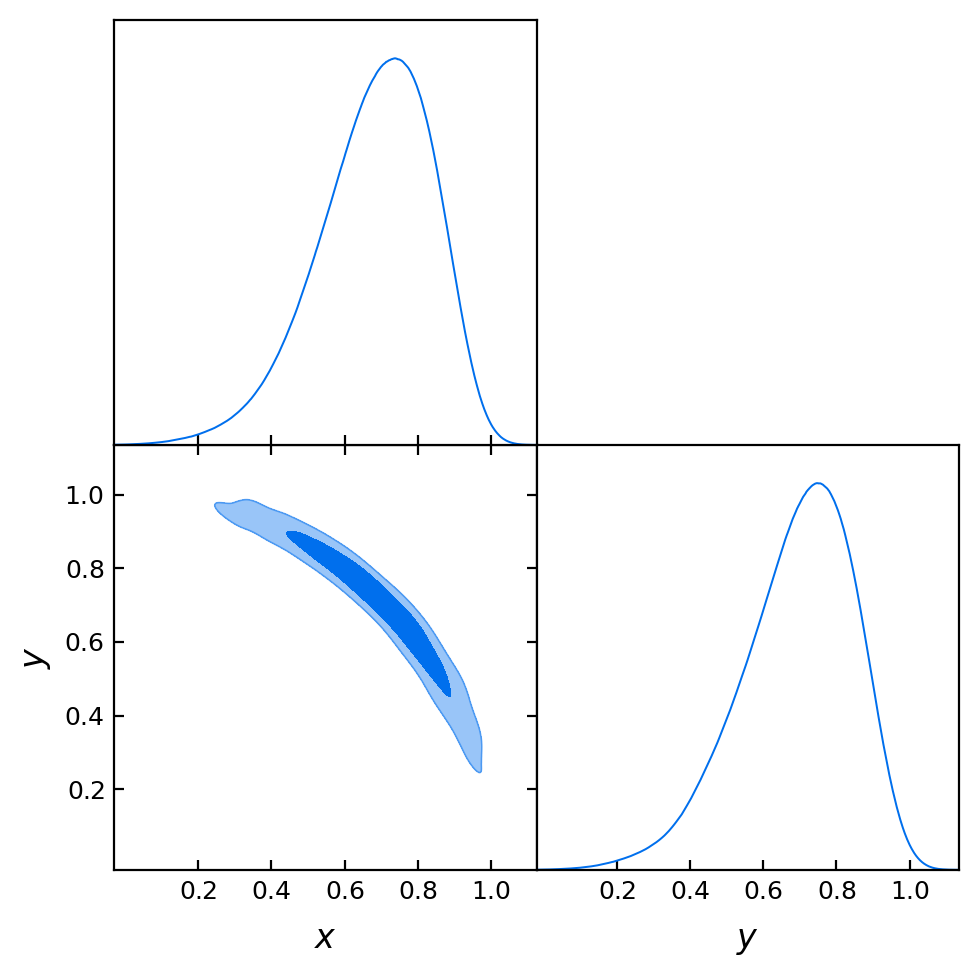

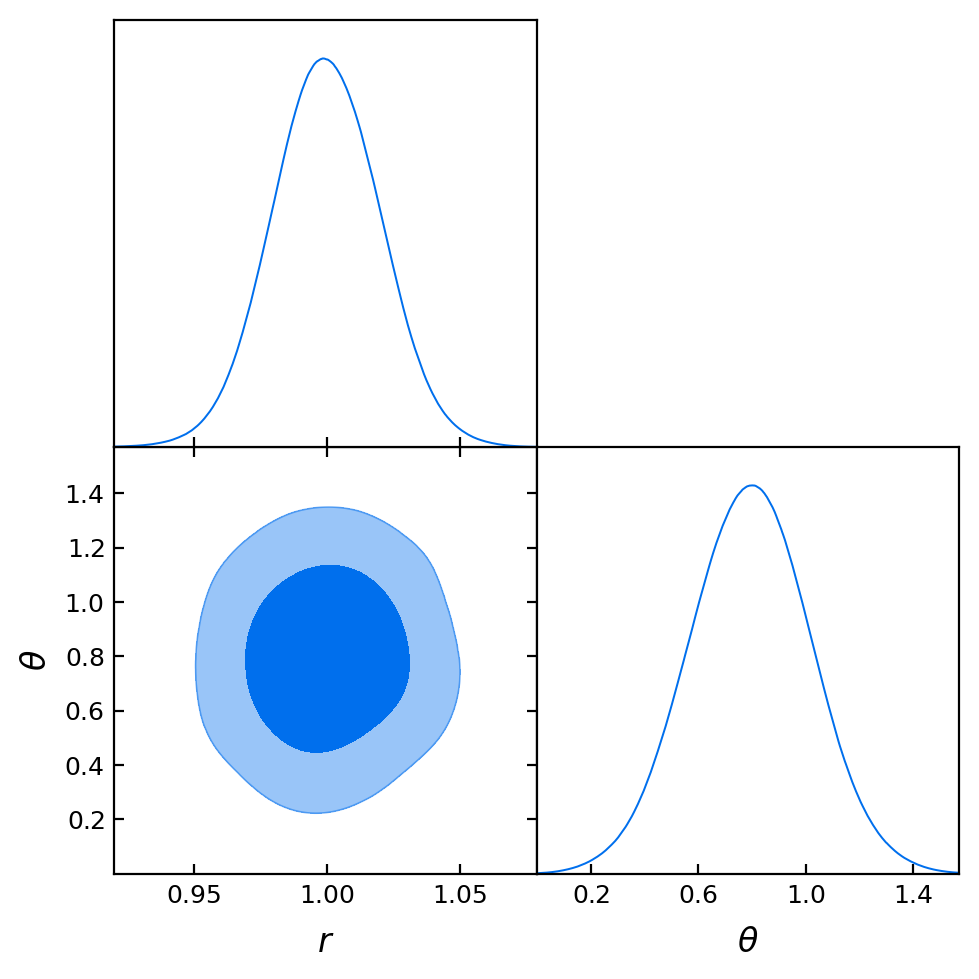

In [12]:
gdsamples_rtheta = sampler_rtheta.products(to_getdist=True, skip_samples=0.3)["sample"]
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples_rtheta, ["x", "y"], filled=True)
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples_rtheta, ["r", "theta"], filled=True)